In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import re
from pathlib import Path

from das.plotting import plot_results, set_plt_settings


RESULTS_DIR = Path("../Results_Cleaned")
PLOTS_DIR = Path("plots/mlp")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def put_together(data1,data2):
    for i in range(len(data1)):
        for a in data2[i].keys():
            if a!="accuracy":
                data1[i][a]=data2[i][a]
    return data1

def calculate_mean_std(dict_list):
    if not dict_list:
        return {}

    def recursive_stats(keys, data):
        if isinstance(data[0], dict):
            return {key: recursive_stats(keys + [key], [d[key] for d in data]) for key in data[0]}
        else:
            values = np.array(data)
            return (values.mean(), values.std())

    return recursive_stats([], dict_list)

In [4]:
layers = ["Layer1", "Layer2", "Layer3"]
intervention_sizes =   ['[[0], [1]]',
                        '[[0, 1], [2, 3]]',
                        '[[0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15]]'
                        ]
layers_label=["Layer 1","Layer 2","Layer 3"]
intervention_label=["Intervetion Size 1","Intervetion Size 2","Intervetion Size 8"]
hiddensize_range=list(range(1,17))
def Prepare_Data(results,layers,intervention_sizes,layers_label,intervention_label,hiddensize_range):
    residict={}
    for achiddensize in hiddensize_range:
        achiddensize=str(achiddensize)
        for aclayer_pos,aclayer in enumerate(layers):
            if layers_label[aclayer_pos] not in residict:
                residict[layers_label[aclayer_pos]]={}
            for acint_pos, acint in enumerate(intervention_sizes):
                if intervention_label[acint_pos] not in residict[layers_label[aclayer_pos]]:
                    residict[layers_label[aclayer_pos]][intervention_label[acint_pos]]=[[],[]]
                residict[layers_label[aclayer_pos]][intervention_label[acint_pos]][0].append(results[achiddensize][aclayer][acint][0])
                residict[layers_label[aclayer_pos]][intervention_label[acint_pos]][1].append(results[achiddensize][aclayer][acint][1])
    return residict


In [5]:

def make_plot(results, mean_data, hiddensize_range,layers,intervention_sizes,url):
    sub_y_min = 0.4
    sub_y_max = 1
    meancolor = (0/255, 128/255, 255/255)
    std_color = (52/255, 225/255, 235/255)
    rotationmean_color = (0/255, 153/255, 0/255)
    # Create a 3x3 grid for subplots
    fig, axes = plt.subplots(3, 3, figsize=(12, 8))
    
    # Iterate over the plot_data dictionary to create subplots
    for i, layer in enumerate(results):
        for j, label in enumerate(results[layer]):
            ax = axes[i, j]
            
            y_values_mean = results[layer][label][0]
            y_values_std = results[layer][label][1]
            
            # Plot the mean values
            ax.plot(hiddensize_range, y_values_mean, marker='o', color=meancolor)
            constant_y = mean_data[layers[i]][intervention_sizes[j]][0]
            ax.axhline(y=constant_y, color=rotationmean_color, linestyle='--', linewidth=2)
            
            # Add the standard deviation shading (±3 std)
            upper_bound = [m + 2*s for m, s in zip(y_values_mean, y_values_std)]
            lower_bound = [m - 2*s for m, s in zip(y_values_mean, y_values_std)]
            ax.fill_between(hiddensize_range, lower_bound, upper_bound, 
                color=std_color, alpha=0.5, linewidth=0)
            
            ax.set_ylim(sub_y_min, sub_y_max)
            
            if i != 2:
                ax.set_xlabel('')
                ax.set_xticks([])
            else:
                ax.set_xlabel(label)
                
            if j != 0:
                ax.set_ylabel('')
                ax.set_yticks([])
            else:
                ax.set_ylabel(layer)
            
            #plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    
    # Save the plot
    plt.savefig(url, bbox_inches='tight')
    plt.show()
    plt.close()




def make_plot_single_layer(results, mean_data, target_layer, intervention_sizes, out_file_name):
    layer_data = results.get(target_layer)
    if layer_data:
        num_points = len(layer_data[next(iter(layer_data.keys()))][0])
        print(num_points)
        hidden_sizes_index = [i+1 for i in range(num_points)]
        layer_data = results.get(target_layer)
        mean_data_for_df = {}
        std_data_for_df = {}
        intervention_sizes = [] # Keep track of column order

        for intervention_key, (means, stds) in layer_data.items():
            intervention_sizes.append(intervention_key)
            if len(means) == len(hidden_sizes_index) and len(stds) == len(hidden_sizes_index):
                mean_data_for_df[intervention_key] = means
                std_data_for_df[intervention_key] = stds
            else:
                print(f"Warning: Data length mismatch for {intervention_key}. Expected {len(hidden_sizes_index)}, got {len(means)}. Skipping.")

        # Create DataFrames with the defined index
        iia_mean_df = pd.DataFrame(mean_data_for_df, index=hidden_sizes_index)
        iia_std_df = pd.DataFrame(std_data_for_df, index=hidden_sizes_index)

        # Ensure columns are in a consistent order (optional but good practice)
        iia_mean_df = iia_mean_df[intervention_sizes]
        iia_std_df = iia_std_df[intervention_sizes]

        # Create the mapping for x-coordinates (using simple numeric positions)
        x_coords_map = {label: i for i, label in enumerate(hidden_sizes_index)}

        # --- Plotting ---
        # Use the modified plot_results function

        fig, ax = plot_results(
            iia_df=iia_mean_df,
            acc_df=pd.DataFrame(), # No accuracy data in this specific example format
            iia_std_df=iia_std_df, # Pass the standard deviation data
            x_coords_map=x_coords_map,
            x_label="$d_{\\mathrm{h}}$", # Customize axis label
            y_label="Accuracy", # Customize axis label
            title=f"Results for {target_layer}", # Customize title
            error_bar_alpha=0.25, # Customize alpha
            error_bar_multiplier=1.0, # Plot +/- 1 std dev
            # Add any other plot_results customization parameters as needed
            legend_font_size=18,
            xtick_label_rotation=0,
            figsize=(8, 4.5),
            x_axis_label_pad=10
        )
        
        # Add a single legend entry for the reference lines
        ax.plot([], [], color='black', linestyle='--', linewidth=2, label='Accuracy')
        
        ax.tick_params(axis='both', which='major', labelsize=24)
        # Set axis label sizes
        ax.set_xlabel(ax.get_xlabel(), fontsize=24)
        ax.set_ylabel(ax.get_ylabel(), fontsize=24)
        
        # Set title size if needed
        # Set x-axis ticks to show only powers of 2 and 1
        power_of_2_ticks = [1, 2, 4, 8, 16]
        ax.set_xticks([el-1 for el in power_of_2_ticks])
            
        # Adjust horizontal alignment of tick labels to center them properly
        for label in ax.get_xticklabels():
            label.set_ha('center')

        set_plt_settings()
        
        plt.tight_layout()
        plt.draw()
        
        fig.savefig(out_file_name, bbox_inches='tight')
    
        return fig, ax

    else:
        print(f"Error: Data for layer '{target_layer}' not found in results.")

## Plot for Both Equality Relations

16
Accuracy DataFrame is empty. Plotting IIA only if available.
16
Accuracy DataFrame is empty. Plotting IIA only if available.
16
Accuracy DataFrame is empty. Plotting IIA only if available.


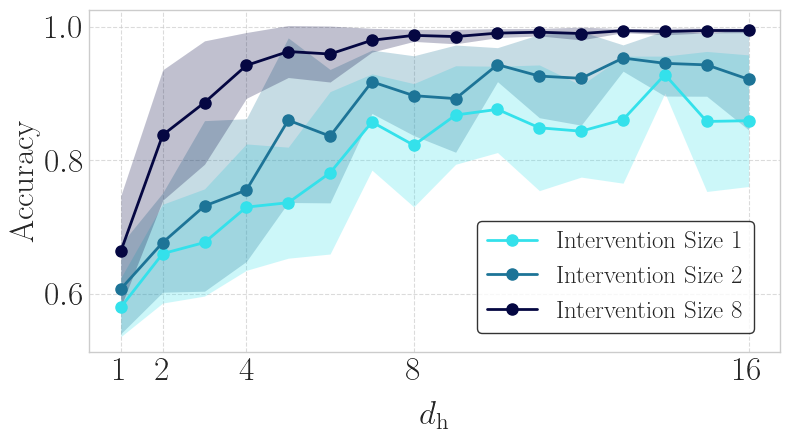

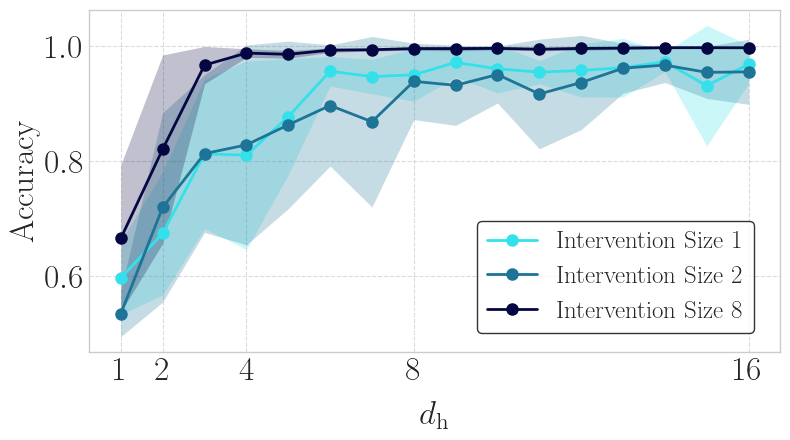

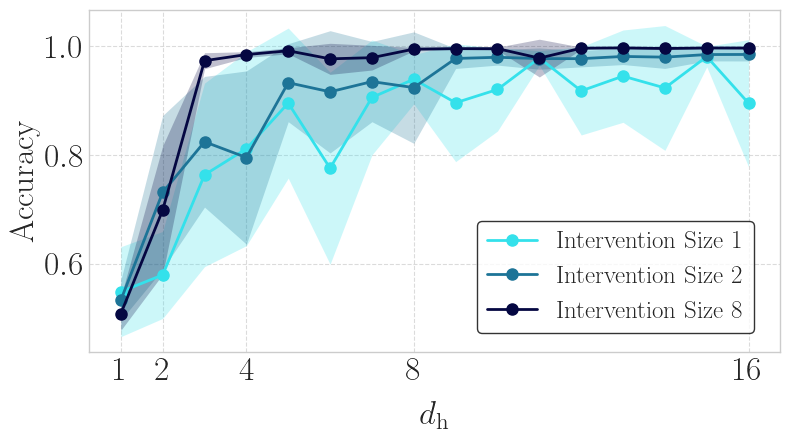

In [7]:
layers = ["Layer1", "Layer2", "Layer3"]
intervention_sizes =   ['[[0], [1]]',
                        '[[0, 1], [2, 3]]',
                        '[[0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15]]'
                        ]
layers_label=["Layer 1","Layer 2","Layer 3"]
intervention_label=["Intervention Size 1","Intervention Size 2","Intervention Size 8"]
hiddensize_range=list(range(1,17))
TaskName="Both_Equality_Relations"


with open(RESULTS_DIR / 'HiddenSizeProgression/Both_Equality_Relations/results_1.json') as f:
    results1= json.load(f)
with open(RESULTS_DIR / 'HiddenSizeProgression/Both_Equality_Relations/results_2.json') as f:
    results2= json.load(f)
with open(RESULTS_DIR / 'Standard_DAS/Rotation/FullyTrained/Both_Equality_Relations/results.json') as f:
    mean_data= json.load(f)
mean_data=calculate_mean_std(mean_data)
results=put_together(results1,results2)
results=calculate_mean_std(results)
results=Prepare_Data(results,layers,intervention_sizes,layers_label,intervention_label,hiddensize_range)

PLOTS_DIR.mkdir(parents=True, exist_ok=True)
for layer in layers_label:
    fig, ax = make_plot_single_layer(results, mean_data, layer, intervention_sizes, PLOTS_DIR / f'hidden_size_{TaskName}_{layer}.pdf'.replace(" ", "_"))


## Plot for Left Equality Relation

In [6]:
layers = ["Layer1", "Layer2", "Layer3"]
intervention_sizes =   ['[[0], [1]]',
                        '[[0, 1], [2, 3]]',
                        '[[0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15]]'
                        ]
layers_label=["Layer 1","Layer 2","Layer 3"]
intervention_label=["Intervetion Size 1","Intervetion Size 2","Intervetion Size 8"]
hiddensize_range=list(range(1,17))

with open('../HiddenSizeProgression/Left_Equality_Relation/results_1.json') as f:
    results1= json.load(f)
with open('../HiddenSizeProgression/Left_Equality_Relation/results_2.json') as f:
    results2= json.load(f)
with open('../Standard_DAS/Rotation/FullyTrained/Left_Equality_Relation/results.json') as f:
    mean_data= json.load(f)
mean_data=calculate_mean_std(mean_data)
results=put_together(results1,results2)
results=calculate_mean_std(results)
results=Prepare_Data(results,layers,intervention_sizes,layers_label,intervention_label,hiddensize_range)
make_plot(results,mean_data,hiddensize_range,layers,intervention_sizes,"./Hidden_Size_Plots/Hidden_Size_Progression_Left_Equality_Relation.png")

## Plot for Identity of First Argument

In [7]:
layers = ["Layer1", "Layer2", "Layer3"]
intervention_sizes =   ['[[0]]',
                        '[[0, 1]]',
                        '[[0, 1, 2, 3, 4, 5, 6, 7]]'
                        ]
layers_label=["Layer 1","Layer 2","Layer 3"]
intervention_label=["Intervetion Size 1","Intervetion Size 2","Intervetion Size 8"]
hiddensize_range=list(range(1,17))

with open('../HiddenSizeProgression/Identity_of_First_Argument/results_1.json') as f:
    results1= json.load(f)
with open('../HiddenSizeProgression/Identity_of_First_Argument/results_2.json') as f:
    results2= json.load(f)
with open('../Standard_DAS/Rotation/FullyTrained/Identity_of_First_Argument/results.json') as f:
    mean_data= json.load(f)
mean_data=calculate_mean_std(mean_data)
results=put_together(results1,results2)
results=calculate_mean_std(results)
results=Prepare_Data(results,layers,intervention_sizes,layers_label,intervention_label,hiddensize_range)
make_plot(results,mean_data,hiddensize_range,layers,intervention_sizes,"./Hidden_Size_Plots/Hidden_Size_Progression_Identity_of_First_Argument.png")

## Plot for AndOrAnd

In [8]:
layers = ["Layer1", "Layer2", "Layer3"]
intervention_sizes =   ['[[0], [1]]',
                        '[[0, 1], [2, 3]]',
                        '[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]]'
                        ]
layers_label=["Layer 1","Layer 2","Layer 3"]
intervention_label=["Intervetion Size 1","Intervetion Size 2","Intervetion Size 12"]
hiddensize_range=list(range(1,17))

with open('../HiddenSizeProgression/AndOrAnd/results_1.json') as f:
    results1= json.load(f)
with open('../HiddenSizeProgression/AndOrAnd/results_2.json') as f:
    results2= json.load(f)
with open('../Standard_DAS/Rotation/FullyTrained/AndOrAnd/results.json') as f:
    mean_data= json.load(f)
mean_data=calculate_mean_std(mean_data)
results=put_together(results1,results2)
results=calculate_mean_std(results)
results=Prepare_Data(results,layers,intervention_sizes,layers_label,intervention_label,hiddensize_range)
make_plot(results,mean_data,hiddensize_range,layers,intervention_sizes,"./Hidden_Size_Plots/Hidden_Size_Progression_AndOrAnd.png")

## Plot for AndOrAnd

In [9]:
layers = ["Layer1", "Layer2", "Layer3"]
intervention_sizes =   ['[[0], [1]]',
                        '[[0, 1], [2, 3]]',
                        '[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]]'
                        ]
layers_label=["Layer 1","Layer 2","Layer 3"]
intervention_label=["Intervetion Size 1","Intervetion Size 2","Intervetion Size 12"]
hiddensize_range=list(range(1,17))

with open('../HiddenSizeProgression/AndOr/results_1.json') as f:
    results1= json.load(f)
with open('../HiddenSizeProgression/AndOr/results_2.json') as f:
    results2= json.load(f)
with open('../Standard_DAS/Rotation/FullyTrained/AndOr/results.json') as f:
    mean_data= json.load(f)
mean_data=calculate_mean_std(mean_data)
results=put_together(results1,results2)
results=calculate_mean_std(results)
results=Prepare_Data(results,layers,intervention_sizes,layers_label,intervention_label,hiddensize_range)
make_plot(results,mean_data,hiddensize_range,layers,intervention_sizes,"./Hidden_Size_Plots/Hidden_Size_Progression_AndOr.png")